# Belief

Belief is a central concept in stochastic estimation and control.  In many real world problems, the exact state of the system $x \in \mathbb{R}^n$ is unknown, and thus considered a random variable.  We represent belief in state as a probability distribution $p(x)$.  This distribution is considered generative, as we are able to generate samples from it.  With this statistical representation, we can reason about the most likely state (expectation) as well as a level of trust in it (confidence/uncertainty).  In Sia, all distributions inherit from the `sia.Distribution` virtual base class and are multivariate.

We can categorize distributions into two broad classes: parametric and non-parametric.  Parametric distributions $p(x;\theta)$ are represented by a relatively small parameter set $\theta\in\mathbb{R}^p$ and typically have basic shapes that are fast to compute.  Non-parametric distributions $p(x;\mathcal{D})$ are directly represented by sampled data $D=\{x_1, \ldots, x_N\}$ and therefore have much more complex shapes at the expense of compute time.

Many software packages provide statistical representations, but because belief is central to stochastic estimation.  Several common/useful builtins are included with `sia`, with the ability to integrate with other libraries.  The following table summarizes the distributions available in Sia, which are discussed in detail below.

| Distribution   | Type           | Variables   | Support  | Notes                                          |
| -------------- | -------------- | ----------- | -------- | ---------------------------------------------- |
| Gaussian       | Parametric     | Continuous  | Infinite | Easily integrates with linear models           |
| Uniform        | Parametric     | Continuous  | Bounded  | Maximum entropy (lowest confidence)            |
| Dirichlet      | Parametric     | Continuous  | Bounded  | Conjugate prior of Categorical                 |
| Categorical    | Parametric     | Discrete    | Bounded  | Parameterized by a continuous (one-hot) vector |
| Particles      | Non-parametric | Continuous  | Infinite | Collection of weighted random samples          |
| Kernel density | Non-parametric | Continuous  | Mixed    | Smooths weighted random samples                |

**References**

1. [S. Thrun, W. Burard, and D. Fox, Probabilistic Robotics, MIT Press, 2004.](https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf)

2. [B. E. Hansen, Lecture Notes on Nonparametrics, University of Wisconsin, 2009.](https://www.ssc.wisc.edu/~bhansen/718/NonParametrics1.pdf)

3. [Hardle et. al., Nonparametric and Semiparametric models, Springer Series in Statistics, 2004.](https://link.springer.com/book/10.1007/978-3-642-17146-8)

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

## Gaussian
The `sia.Gaussian` (Normal) distribution $x\sim\mathcal{N}(\mu,\Sigma)$ is the most widely used statistical representation due to its versatility within linear models.  It is directly parameterized by its first and second statistical moments, the mean $\mu$ and covariance $\Sigma$.  In Sia, on class construction or covariance updates, the square root of the covariance is computed via the Cholesky decomposition.

$$
\Sigma = L L^\top
$$

The decomposition dictates that the covariance be positive definite.  The $L$ factorization and its inverse $L^{-1}$ is cached and used to speed up evaluations such as the log probability, the mahalanobis distance, and sample generation.

\begin{gather}
\log p(x) = -\frac{1}{2}\left(n\log{2 \pi} + 2 \text{tr} \{\log L\} + y^\top y \right),\quad y = L^{-1}(x-\mu) \\
\text{mahal}(x) = \sqrt{y^\top y},\quad y = L^{-1}(x-\mu) \\
x = L s + \mu, \quad s\sim\mathcal{N}(0,1)
\end{gather}

## Uniform
The `sia.Uniform` distribution $x\sim\mathcal{U}(a,b)$ is the maximum entropy distribution.  This is useful when the true state is completely unknown and equaly likely with a box region.  It is parameterized by its lower $a$ and upper $b$ bounds.  The log probability is equivalent for all samples within the support and defined

$$
\log p(x) = \left\{\begin{array}{ll}
-\sum\log(b-a) & \text{if}~x \in \mathcal{U} \\
-\infty & \text{else}
\end{array}\right.
$$

The following example illustrates several Gaussian and Uniform distributions in 1D.

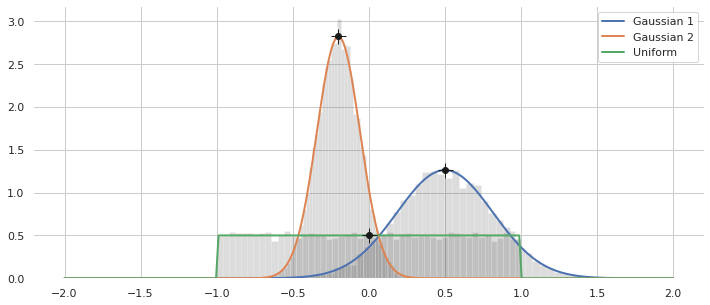

In [2]:
distributions = {
    "Gaussian 1": sia.Gaussian(mean=0.5, variance=0.1),
    "Gaussian 2": sia.Gaussian(mean=-0.2, variance=0.02),
    "Uniform": sia.Uniform(lower=-1.0, upper=1.0),
}
        
# Plot the probabilities
f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-2, 2, 250)
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb1d(dist, x))
    plt.plot(x, prob, label=name, lw=2)
    
    # Add dots for the distribution means
    mean = dist.mean()
    plt.plot(mean, np.exp(dist.logProb(mean)), ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    plt.plot(mode, np.exp(dist.logProb(mode)), "+k", ms=15)
    
    # Draw samples and plot a histogram
    s_sia = dist.samples(10000)
    plt.hist(np.array(s_sia), 50, density=True, color="k", edgecolor=None,  alpha=0.15)

plt.legend();

The following example illustrates several 2D Gaussian distributions.

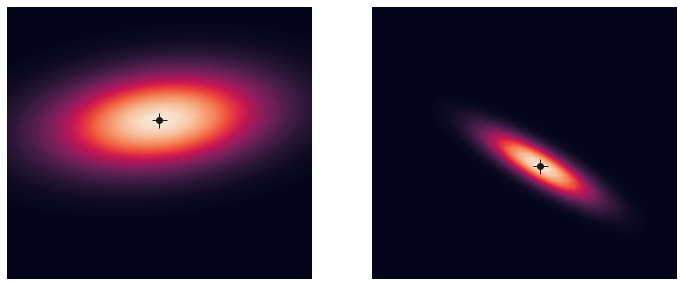

In [3]:
distributions = {
    "Gaussian 1": sia.Gaussian(mean=np.array([0, 0.5]),
                               covariance=np.array([[2, 0.2], [0.2, 0.5]])),
    "Gaussian 2": sia.Gaussian(mean=np.array([0.3, -0.5]),
                               covariance=np.array([[0.5, -0.3], [-0.3, 0.25]])),
}

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)
xx, yy = np.meshgrid(x, y)
i = 0
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Add dots for the distribution means
    mean = dist.mean()
    ax[i].plot(mean[0], mean[1], ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    ax[i].plot(mode[0], mode[1], "+k", ms=15)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    
    i+=1

## Dirichlet 
The `sia.Dirichlet` distribution $x\sim \mathcal{D}ir(\alpha)$ is commonly used as the conjugate prior distribution for categorical variables (see below).  Its support is $\sum x_i = 1, x_i \in (0, 1)$, and samples from the distribution can be used as category probabilities.  It is parameterized by a positive real vector of component mixtures $\alpha\in\mathbb{R}_+^n$.  In order to avoid a degenerate condition, evaluation methods in `sia`apply the normalization $\sum x_i = 1$ and a small offset to ensure that $x>0$.  The log probability is defined

$$
\log p(x) = \left\{\begin{array}{ll}
\left(\log \Gamma \left( \sum_i \alpha_i \right) - \sum_i \log \Gamma(\alpha_i) + \sum_i (\alpha_i - 1) \log x_i \right) & \text{if} x~\in \mathcal{D}ir \\
-\infty & \text{else}
\end{array}\right.
$$

The mode evaluation is invalid for $\alpha <1$ concentrations since this results in a multimodal distribution.  Sampling is performed from $n$ independent gamma distributions.  The Beta distribution is a special case of the Dirichlet when $n=2$.

The following example illustrates several cases of the Beta distribution special case of Dirichlet.

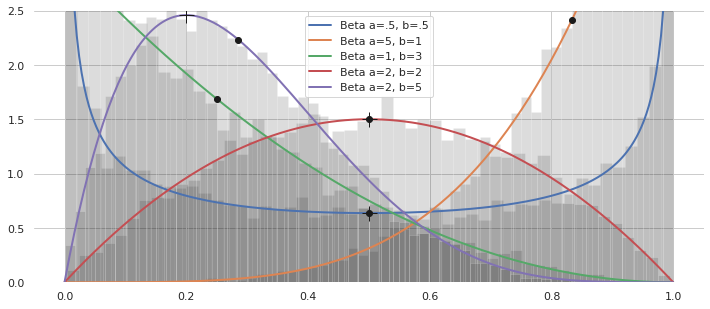

In [4]:
distributions = {
    "Beta a=.5, b=.5": sia.Dirichlet(alpha=.5, beta=.5),
    "Beta a=5, b=1": sia.Dirichlet(alpha=5, beta=1),
    "Beta a=1, b=3": sia.Dirichlet(alpha=1, beta=3),
    "Beta a=2, b=2": sia.Dirichlet(alpha=2, beta=2),
    "Beta a=2, b=5": sia.Dirichlet(alpha=2, beta=5),
}

# Plot the probabilities
f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
# Note that the Dirichlet distribution requires 1 dimension for each 
# category, so a binary classifier has dimension 2.  Here we only plot
# the 1st axis.  The 2nd axis is the reflection of the Beta random variable.
x = np.linspace(0, 1, 250)
axis = 0
for name, dist in distributions.items():
    pass
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, x, 1-x))
    plt.plot(x, prob, label=name, lw=2)
    
    # Add dots for the distribution means
    mean = dist.mean()
    plt.plot(mean[axis], np.exp(dist.logProb(mean)), ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    plt.plot(mode[axis], np.exp(dist.logProb(mode)), "+k", ms=15)
    
    # Draw samples and plot a histogram
    s_sia = dist.samples(10000)
    plt.hist(np.array(s_sia)[:, axis], 50, density=True, color="k", edgecolor=None,  alpha=0.15)

plt.ylim((0, 2.5))
plt.legend();

## Categorical
The `sia.Categorical` distribution $x\sim\mathcal{C}at(p)$ represents discrete random variables for one of $n$ possible categories.  It is parameterized by the one-hot vector of category probabilities $p\in\mathbb{R}^n$ with support $\sum_i p_i = 1, x_i \in [0, 1]$.  Note that the support of the parameterization is equivalent to the support of the Dirichlet random variable.  The log probability for a one-hot vector encoded sample $x\in\mathbb{R}^n$ is defined

$$
\log p(x) = \log \sum_i p_i x_i
$$

In Sia, the categorical distribution provides methods to classify the parameterization, i.e. map the category probabilities to the maximum likelihood class

$$
i^* = \arg\max_i p_i
$$

Because samples are encoded as one-hot vectors, methods to convert between class indices and one-hot vector encodings are included.

## Particles
The `sia.Particles` distribution is simply a collection of $i = \{1,\ldots,N\}$ random samples $s_i \sim p(x)$.  The particle distribution is used by Monte Carlo-style algorithms such as the particle filter for representing complex distributions, e.g. non-Gaussian and potentially with multiple modes.

Each particle is represented by a sample and a corresponding weight, $\{s_i, w_i\}_i$, where $\sum_i w_i = 1$.  Unless explicitly specified, weights are chosen to be equal (uniform).  The class allows to choose whether the weights are used in the statistics computations.  The following table shows how the metrics are computes for samples $s_i$ and weights $w_i$.  Note that covariance is unbiased using Bessel's correction.

| Statistic      | Sample                                                        | Weighted                                                                       |
| -------------- | ------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| Mean           | $$\mu =\frac{1}{N} \sum_i s_i$$                               | $$\mu = \sum_i w_i s_i$$                                                       |
| Mode           | Equivalent to mean                                            | $$s_i^* = \arg \max_i \{ w_i \}$$                                                |
| Covariance     | $$\Sigma = \frac{1}{N-1} \sum_i (s_i - \mu)(s_i - \mu)^\top$$ | $$\Sigma = \frac{1}{1 - \sum_i w_i^2} \sum_i w_i (s_i - \mu)(s_i - \mu)^\top$$ |

The log probability is defined as the $\log p(x) = \log w_i$ where $i$ is the index of the nearest neighbor to $x$.

Below we show two particle distributions initialized from Gaussians.  One uses weights in the statistics compuations, the other does not.  Note in both cases the weights are uniform.

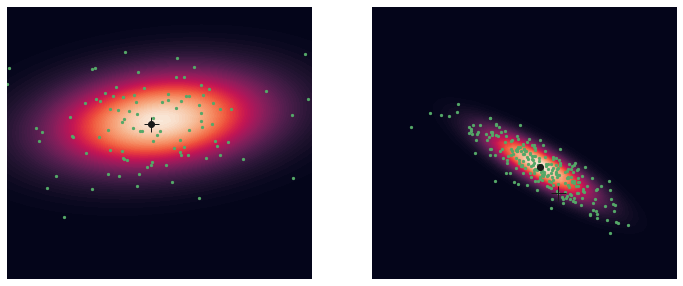

In [5]:
# Create the particle distributions by sampling the parametric Gaussians from before
distributions = {
    "Gaussian 1": sia.Gaussian(mean=np.array([0, 0.5]),
                               covariance=np.array([[2, 0.2], [0.2, 0.5]])),
    "Gaussian 2": sia.Gaussian(mean=np.array([0.3, -0.5]),
                               covariance=np.array([[0.5, -0.3], [-0.3, 0.25]])),
}

samples = {
    "Gaussian 1": sia.Particles.init(distributions["Gaussian 1"], 
                                     num_particles=100,
                                     weighted_stats=False),
    "Gaussian 2": sia.Particles.init(distributions["Gaussian 2"], 
                                     num_particles=250,
                                     weighted_stats=True),
}

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Add the samples to the density plots for the parameteric distributions
i = 0
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Add scatter plots for the sample distributions
    sample = samples[name]
    ax[i].scatter(sample.values()[0, :], sample.values()[1, :], s=5, color="g")
    
    # Adds dots for the sample distribution means
    mean = sample.mean()
    ax[i].plot(mean[0], mean[1], ".k", ms=12)
    
    # Adds plusses for the sample distribution modes
    mode = sample.mode()
    ax[i].plot(mode[0], mode[1], "+k", ms=15)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    
    i+=1

### Kernel density estimators

The `sia.KernelDensity` distribution is a specialization of the particle distribution that builds local kernels around each particle.  This smooths the log probability, improves sampling, and mode finding.  The log probability for the multivariate kernel density is 

$$
\log p(x) = \log \sum_i^N w_i K_H(x-s_i).
$$

The function $K_H$ is a scaled kernel

$$
K_H(x) = \frac{1}{|H|} K(H^{-1} x)
$$

with bandwidth matrix $H > 0$ and kernel function $K(x)$.  Available kernel functions include the uniform, Gaussian, and Epanechnikov kernels.  The bandwidth $H$ affects the smoothing, with higher values increases the smoothing.  By default, the Scott's generalized rule of thumb is used to find the bandwidth.  Bandwidth can also be user specified.

This example shows several kernel densities for samples drawn from the standard normal distribution.

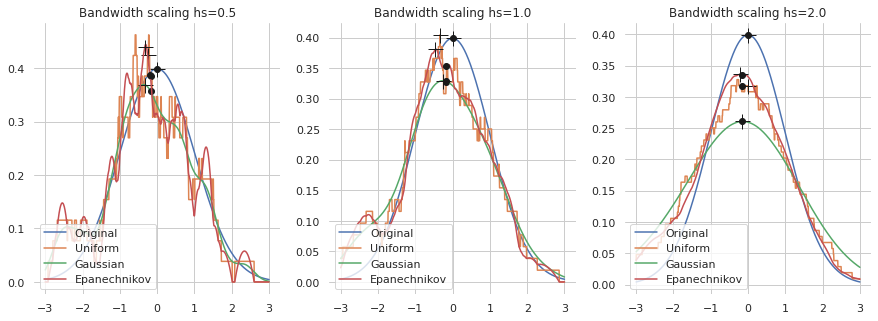

In [6]:
# Test cases
Nsamples = 50
bandwidths = [0.5, 1.0, 2.0]
kernels = [sia.UniformKernel(1), sia.GaussianKernel(1), sia.EpanechnikovKernel(1)]
dist_names = ["Original", "Uniform", "Gaussian", "Epanechnikov"]

# Define the standard normal and sample from it
original = sia.Gaussian(mean=0, variance=1)
sample = sia.Particles.init(original, Nsamples)

# Plot the 1D kernel densities
ncols = len(bandwidths)
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5))
sns.despine(f, left=True, bottom=True)

x = np.linspace(-3, 3, 1001)
for i in range(ncols):
    for j in range(len(dist_names)):
        name = dist_names[j]
        if j == 0:
            dist = original
        else:
            # Create a kernel density and set the bandwidth scaling
            dist = sia.KernelDensity(sample, 
                                     kernel=kernels[j - 1], 
                                     mode=sia.KernelDensity.SCOTT_RULE,
                                     bandwidth_scaling=bandwidths[i])
            
        # Helper to evaluate the probability for multiple samples
        prob = np.exp(sia.logProb1d(dist, x))
        ax[i].plot(x, prob, label=name)
    
        # Add dots for the distribution means
        mean = dist.mean()
        ax[i].plot(mean, np.exp(dist.logProb(mean)), ".k", ms=12)
    
        # Add plusses for the distribution modes
        mode = dist.mode()
        ax[i].plot(mode, np.exp(dist.logProb(mode)), "+k", ms=15)
        ax[i].legend(loc="lower left")
        ax[i].set_title("Bandwidth scaling hs={}".format(bandwidths[i]))

Support for multidimensional kernel densities is provided, although KDEs are known to suffer from the curse of dimensionality.  As the state dimension increases, they become increasingly less useful.  This example shows kernel densities for samples drawn from a 2D Gaussian, this time using Scott's rule of thumb for the bandwidth.

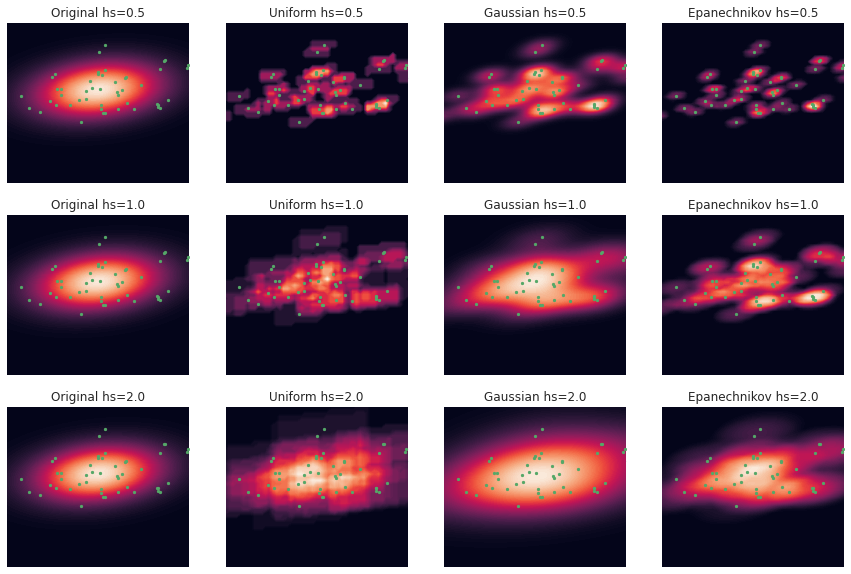

In [7]:
# Define the 2D original density
original = sia.Gaussian(mean=np.array([0, 0.5]),
                        covariance=np.array([[2, 0.2], [0.2, 0.5]]))
sample = sia.Particles.init(original, Nsamples)
kernels = [sia.UniformKernel(2), sia.GaussianKernel(2), sia.EpanechnikovKernel(2)]
dist_names = ["Original", "Uniform", "Gaussian", "Epanechnikov"]


# Plot the 2D probability densities
nrows = len(bandwidths)
ncols = len(dist_names)
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
sns.despine(f, left=True, bottom=True)

for i in range(nrows):
    for j in range(ncols):
        name = dist_names[j]
        if j == 0:
            dist = original
        else:
            # Create a kernel density and set the bandwidth scaling
            dist = sia.KernelDensity(sample, 
                                     kernel=kernels[j - 1], 
                                     mode=sia.KernelDensity.SCOTT_RULE,
                                     bandwidth_scaling=bandwidths[i])
            
        # Helper to evaluate the probability for multiple samples
        prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
        ax[i, j].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
        # Add scatter plots for the sample distributions
        ax[i, j].scatter(sample.values()[0, :], sample.values()[1, :], s=5, color="g")
        
        ax[i, j].set_xlim((-3, 3))
        ax[i, j].set_ylim((-3, 3))
        ax[i, j].axis("off")
        ax[i, j].set_title("{} hs={}".format(name, bandwidths[i]))